In [202]:
from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Conv2DTranspose, Flatten, UpSampling2D
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from keras.utils import np_utils


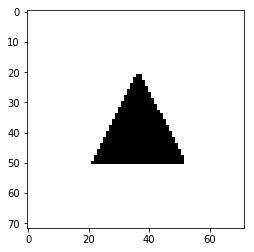

In [203]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(0, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(0)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(0, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

# Simple classification 

In [204]:
[X_train, Y_train] = generate_dataset_classification(300, 20)


Creating data:
0
100
200


In [206]:
print('X_train shape : ' , X_train.shape)
print('Y_train.shape before reshape : ', Y_train.shape)
Y_train = np_utils.to_categorical(Y_train, 3)
print('Y_train.shape after reshape : ', Y_train.shape)




X_train shape :  (300, 5184)
Y_train.shape before reshape :  (300,)
Y_train.shape after reshape :  (300, 3)


In [210]:
model = Sequential()
#Add a dense layer
model.add(Dense(3, input_shape=(5184,)))
#softmax layer pour avoir une proba de distribution
model.add(Activation('softmax'))

sgd = SGD(lr=0.001)
#adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

model.compile(loss='categorical_crossentropy' , optimizer=sgd)
model.fit(X_train, Y_train, epochs=150, batch_size=32)


Epoch 1/150
300/300 [==============================] - 1s 3ms/step - loss: 1.2380
Epoch 2/150
300/300 [==============================] - 0s 207us/step - loss: 1.0639
Epoch 3/150
300/300 [==============================] - 0s 200us/step - loss: 0.9894
Epoch 4/150
300/300 [==============================] - 0s 193us/step - loss: 0.8582
Epoch 5/150
300/300 [==============================] - 0s 190us/step - loss: 0.8197
Epoch 6/150
300/300 [==============================] - 0s 227us/step - loss: 0.7885
Epoch 7/150
300/300 [==============================] - 0s 193us/step - loss: 0.7742
Epoch 8/150
300/300 [==============================] - 0s 213us/step - loss: 0.7222
Epoch 9/150
300/300 [==============================] - 0s 193us/step - loss: 0.6526
Epoch 10/150
300/300 [==============================] - 0s 227us/step - loss: 0.6329
Epoch 11/150
300/300 [==============================] - 0s 253us/step - loss: 0.6067
Epoch 12/150
300/300 [==============================] - 0s 203us/step - loss

300/300 [==============================] - 0s 257us/step - loss: 0.1885
Epoch 98/150
300/300 [==============================] - 0s 287us/step - loss: 0.1820
Epoch 99/150
300/300 [==============================] - 0s 203us/step - loss: 0.1850
Epoch 100/150
300/300 [==============================] - 0s 220us/step - loss: 0.1816
Epoch 101/150
300/300 [==============================] - 0s 237us/step - loss: 0.1859
Epoch 102/150
300/300 [==============================] - 0s 174us/step - loss: 0.1804
Epoch 103/150
300/300 [==============================] - 0s 208us/step - loss: 0.1782
Epoch 104/150
300/300 [==============================] - 0s 193us/step - loss: 0.1717
Epoch 105/150
300/300 [==============================] - 0s 193us/step - loss: 0.1760
Epoch 106/150
300/300 [==============================] - 0s 253us/step - loss: 0.1733
Epoch 107/150
300/300 [==============================] - 0s 277us/step - loss: 0.1712
Epoch 108/150
300/300 [==============================] - 0s 277us/step

On a bien une loss function qui décroit à chaque epoch avec le sgd. Elle se stabilise après 150epochs

In [208]:
#On vérifie que le modèle classifie bien un rectangle et un disque
X_test = generate_a_rectangle()
X_test2 = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
X_test2 = X_test2.reshape(1, X_test2.shape[0])

In [209]:
print(model.predict(X_test))
print(model.predict(X_test2))

[[1. 0. 0.]]
[[0. 1. 0.]]


On construit le même modèle mais avec un Adam optimizer

In [212]:
model = Sequential()
model.add(Dense(3, input_shape=(5184,)))
model.add(Activation('softmax'))

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

model.compile(loss='categorical_crossentropy' , optimizer=adam)
model.fit(X_train, Y_train, epochs=150, batch_size=32)

Epoch 1/150
300/300 [==============================] - 2s 5ms/step - loss: 2.2672
Epoch 2/150
300/300 [==============================] - 0s 250us/step - loss: 1.2809
Epoch 3/150
300/300 [==============================] - 0s 263us/step - loss: 0.8126
Epoch 4/150
300/300 [==============================] - 0s 260us/step - loss: 0.5688
Epoch 5/150
300/300 [==============================] - 0s 247us/step - loss: 0.4707
Epoch 6/150
300/300 [==============================] - 0s 253us/step - loss: 0.3319
Epoch 7/150
300/300 [==============================] - 0s 253us/step - loss: 0.2759
Epoch 8/150
300/300 [==============================] - 0s 260us/step - loss: 0.2564
Epoch 9/150
300/300 [==============================] - 0s 247us/step - loss: 0.2264
Epoch 10/150
300/300 [==============================] - 0s 237us/step - loss: 0.1988
Epoch 11/150
300/300 [==============================] - 0s 243us/step - loss: 0.1860
Epoch 12/150
300/300 [==============================] - 0s 237us/step - loss

300/300 [==============================] - 0s 200us/step - loss: 0.0081
Epoch 98/150
300/300 [==============================] - 0s 227us/step - loss: 0.0076
Epoch 99/150
300/300 [==============================] - 0s 240us/step - loss: 0.0076
Epoch 100/150
300/300 [==============================] - 0s 224us/step - loss: 0.0075
Epoch 101/150
300/300 [==============================] - 0s 223us/step - loss: 0.0074
Epoch 102/150
300/300 [==============================] - 0s 250us/step - loss: 0.0077
Epoch 103/150
300/300 [==============================] - 0s 243us/step - loss: 0.0071
Epoch 104/150
300/300 [==============================] - 0s 257us/step - loss: 0.0073
Epoch 105/150
300/300 [==============================] - 0s 230us/step - loss: 0.0071
Epoch 106/150
300/300 [==============================] - 0s 243us/step - loss: 0.0071
Epoch 107/150
300/300 [==============================] - 0s 230us/step - loss: 0.0068
Epoch 108/150
300/300 [==============================] - 0s 240us/step

Avec Adam la loss function décroit beaucoup plus rapidement (après 15 epochs on a la même loss que après 150epochs de sgd). De plus avec le momentum Adam permet de sortir d'optimums locaux et de saddle points et on a finalement une loss plus faible après 150epochs

# 4 Visualization of the solution

In [213]:
weights = model.get_weights()
temp_weights = weights[0]

In [214]:
carre = temp_weights[:,0]
circle = temp_weights[:,1]
triangle = temp_weights[:,2]

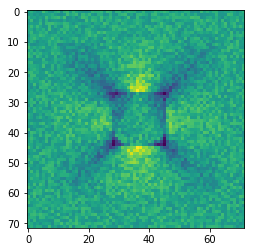

In [215]:
carre = np.reshape(carre, (72,72))
plt.imshow(carre)

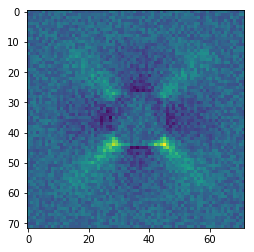

In [216]:
circle = np.reshape(circle, (72,72))
plt.imshow(circle)

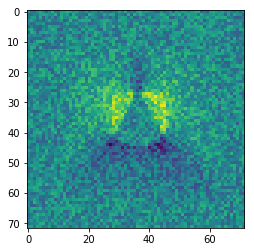

In [217]:
triangle = np.reshape(triangle, (72,72))
plt.imshow(triangle)

En computer vision, les premières couches aprennent des "low level features" (detection de contours, etc...). Ici on a une seule couche et sa visualisation nous permet clairement d'identifier les 3 classes de notre problème'

# A more difficult classification problem

In [218]:
[X_train, Y_train] = generate_dataset_classification(1000, 20, True)
[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
100
200
300
400
500
600
700
800
900
Creating data:
0
100
200


In [219]:
Y_train = np_utils.to_categorical(Y_train, 3)

In [220]:
model = Sequential()
model.add(Dense(3, input_shape=(5184,)))
model.add(Activation('softmax'))
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model.compile(loss='categorical_crossentropy' , optimizer=adam, metrics = ['accuracy'])
model.fit(X_train, Y_train, epochs=200, batch_size=32)

Epoch 1/200
1000/1000 [==============================] - 1s 1ms/step - loss: 2.1170 - acc: 0.3700
Epoch 2/200
1000/1000 [==============================] - 0s 205us/step - loss: 1.0596 - acc: 0.4780
Epoch 3/200
1000/1000 [==============================] - 0s 197us/step - loss: 0.9316 - acc: 0.5640
Epoch 4/200
1000/1000 [==============================] - 0s 197us/step - loss: 0.8999 - acc: 0.5650 0s - loss: 0.9133 - acc: 0.556
Epoch 5/200
1000/1000 [==============================] - 0s 211us/step - loss: 0.8488 - acc: 0.5690
Epoch 6/200
1000/1000 [==============================] - 0s 200us/step - loss: 0.8307 - acc: 0.5900
Epoch 7/200
1000/1000 [==============================] - 0s 216us/step - loss: 0.8224 - acc: 0.6000
Epoch 8/200
1000/1000 [==============================] - 0s 216us/step - loss: 0.7846 - acc: 0.6240
Epoch 9/200
1000/1000 [==============================] - 0s 211us/step - loss: 0.8117 - acc: 0.6040
Epoch 10/200
1000/1000 [==============================] - 0s 201us/step

1000/1000 [==============================] - 0s 241us/step - loss: 0.5053 - acc: 0.7610
Epoch 82/200
1000/1000 [==============================] - 0s 222us/step - loss: 0.5016 - acc: 0.7800
Epoch 83/200
1000/1000 [==============================] - 0s 215us/step - loss: 0.5172 - acc: 0.7700
Epoch 84/200
1000/1000 [==============================] - 0s 202us/step - loss: 0.4548 - acc: 0.8070
Epoch 85/200
1000/1000 [==============================] - 0s 201us/step - loss: 0.5179 - acc: 0.7680
Epoch 86/200
1000/1000 [==============================] - 0s 299us/step - loss: 0.5079 - acc: 0.7690
Epoch 87/200
1000/1000 [==============================] - 0s 256us/step - loss: 0.4731 - acc: 0.8030
Epoch 88/200
1000/1000 [==============================] - 0s 212us/step - loss: 0.4493 - acc: 0.8060
Epoch 89/200
1000/1000 [==============================] - 0s 323us/step - loss: 0.4888 - acc: 0.7700
Epoch 90/200
1000/1000 [==============================] - 0s 319us/step - loss: 0.4718 - acc: 0.7900
Epo

1000/1000 [==============================] - 0s 201us/step - loss: 0.3594 - acc: 0.8540
Epoch 162/200
1000/1000 [==============================] - 0s 320us/step - loss: 0.4679 - acc: 0.7800
Epoch 163/200
1000/1000 [==============================] - 0s 229us/step - loss: 0.4006 - acc: 0.8300
Epoch 164/200
1000/1000 [==============================] - 0s 215us/step - loss: 0.3868 - acc: 0.8400
Epoch 165/200
1000/1000 [==============================] - 0s 258us/step - loss: 0.4258 - acc: 0.7890
Epoch 166/200
1000/1000 [==============================] - 0s 272us/step - loss: 0.3542 - acc: 0.8600
Epoch 167/200
1000/1000 [==============================] - 0s 196us/step - loss: 0.3797 - acc: 0.8400
Epoch 168/200
1000/1000 [==============================] - 0s 244us/step - loss: 0.4392 - acc: 0.7980
Epoch 169/200
1000/1000 [==============================] - 0s 268us/step - loss: 0.4539 - acc: 0.7920
Epoch 170/200
1000/1000 [==============================] - 0s 205us/step - loss: 0.4669 - acc: 0

In [221]:
model.evaluate(X_test, Y_test)

300/300 [==============================] - 0s 1ms/step


[1.2978264053662618, 0.6133333325386048]

Pour ce problème un peu plus complexe, on n'obient que 61% d'accuracy sur le test set avec le même modèle que la question précédente

In [222]:
print(X_train.shape)

(1000, 5184)


In [223]:
X_train = X_train.reshape(X_train.shape[0], 72, 72, 1)
X_train = X_train.astype('float32' )
X_test = X_test.reshape(X_test.shape[0], 72, 72, 1)
X_test = X_test.astype('float32' )

In [224]:
print(X_train.shape)
print(X_test.shape)

(1000, 72, 72, 1)
(300, 72, 72, 1)


In [225]:
model = Sequential()
model.add(Conv2D(16, (5, 5) , input_shape=(72, 72, 1)))
print(model.output_shape)
model.add(MaxPooling2D(pool_size=(2, 2)))
print(model.output_shape)
model.add(Flatten())
print(model.output_shape)

model.add(Dense(3))

model.add(Activation('softmax'))
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
model.compile(loss='categorical_crossentropy' , optimizer=adam, metrics = ['accuracy'])
model.fit(X_train, Y_train, epochs=20, batch_size=32)

(None, 68, 68, 16)
(None, 34, 34, 16)
(None, 18496)
Epoch 1/20
1000/1000 [==============================] - 6s 6ms/step - loss: 1.3372 - acc: 0.4180
Epoch 2/20
1000/1000 [==============================] - 4s 4ms/step - loss: 0.8455 - acc: 0.6640
Epoch 3/20
1000/1000 [==============================] - 4s 4ms/step - loss: 0.7301 - acc: 0.7090
Epoch 4/20
1000/1000 [==============================] - 4s 4ms/step - loss: 0.6571 - acc: 0.7440
Epoch 5/20
1000/1000 [==============================] - 4s 4ms/step - loss: 0.5916 - acc: 0.7950
Epoch 6/20
1000/1000 [==============================] - 4s 4ms/step - loss: 0.5378 - acc: 0.8200
Epoch 7/20
1000/1000 [==============================] - 4s 4ms/step - loss: 0.5239 - acc: 0.8000
Epoch 8/20
1000/1000 [==============================] - 4s 4ms/step - loss: 0.4675 - acc: 0.8490
Epoch 9/20
1000/1000 [==============================] - 4s 4ms/step - loss: 0.4462 - acc: 0.8450A: 0s - loss: 0.4457 - acc:
Epoch 10/20
1000/1000 [=========================

In [226]:
model.evaluate(X_test, Y_test)


300/300 [==============================] - 1s 4ms/step


[0.5444566528002421, 0.7833333333333333]

En remplacant la dense layer par une couche convolutionnelle (convolution + max pooling), on a une augmentation de plus de 10 points d'acuracy, pour 10 fois moins d'epochs !
Les avantages des modèles types CNN sont multiples : il y a en général moins de paramètres car moins de connections donc ces réseaux sont plus faciles à optimiser. Chaque filtre est responsable de rechercher un feature spécifique. Si à un endroit de l'image on retrouve le même pattern alors la feature map pour ces patterns aura les mêmes valeurs : il y a invariance. De plus on instaure une connectivité locale plus ou moins grande selon la taille du filtre qui est absente avec les layers dense.

# A Regression Problem

In [230]:
[X_train, Y_train] = generate_dataset_regression(1000, 20)
[X_test, Y_test] = generate_test_set_regression()


Creating data:
0
100
200
300
400
500
600
700
800
900
Creating data:
0
100
200


In [231]:
print(X_train.shape)
print(X_test.shape)

(1000, 5184)
(300, 5184)


In [232]:
#reshaping
X_train = np.reshape(X_train, (X_train.shape[0], 72, 72, 1))
X_test = np.reshape(X_test, (X_test.shape[0], 72, 72, 1))

In [233]:
print(X_train.shape)
print(X_test.shape)

(1000, 72, 72, 1)
(300, 72, 72, 1)


Ici, comme les sommets des triangles sont générés aléatoirements, si on ne modifie pas les Y notre modèle va apprendre du bruit puisque les Y n'ont aucune réalité physique. En revanche, si les deux premieres coordonnées de chaque yi correspondent au sommet du triangle le plus "à gauche", le modèle va apprendre à prédire le sommet le plus à gauche. Il faut donc donner une structure à notre Y_train.
Arbitrairement j'ai choisi de trier les sommets des triangles par x's croissants. C'est le but de la fonction définie ci-dessous.

In [235]:
#trie les sommets par x croissant
def sort_vertixes(a):
    b = np.zeros(6)
    d = {}
    for i in range(0,6,2):
        d[a[i]] = a[i+1]
    sorted_xs = np.sort(a[::2])
    for i in range(6):
        if i%2 == 0:
            b[i] = sorted_xs[int(i/2)]
        else:
            b[i] = d[sorted_xs[int((i-1)/2)]]
    return b

In [236]:
#On regarde les Y avant modification 
for i in range(5):
    print(Y_train[i])

[0.32765984 0.39741015 0.58271139 0.68460805 0.54966742 0.13549614]
[0.86479809 0.82629084 0.64752313 0.89899355 0.12072161 0.05560161]
[0.14976831 0.62966915 0.12912431 0.4886271  0.27223607 0.21887868]
[0.20370215 0.16904951 0.64609031 0.36712097 0.08776414 0.9974517 ]
[0.46241485 0.73632825 0.95377095 0.16433548 0.45671903 0.48585899]


In [239]:
# On modifie Y_train et Y_test en triant les sommets
for i in range(Y_train.shape[0]):
    Y_train[i] = sort_vertixes(Y_train[i])
for i in range(Y_test.shape[0]):
    Y_test[i] = sort_vertixes(Y_test[i])


In [240]:
#On vérifie qu'on a bien le comportement espéré
for i in range(5):
    print(Y_train[i])

[0.32765984 0.39741015 0.54966742 0.13549614 0.58271139 0.68460805]
[0.12072161 0.05560161 0.64752313 0.89899355 0.86479809 0.82629084]
[0.12912431 0.4886271  0.14976831 0.62966915 0.27223607 0.21887868]
[0.08776414 0.9974517  0.20370215 0.16904951 0.64609031 0.36712097]
[0.45671903 0.48585899 0.46241485 0.73632825 0.95377095 0.16433548]


Ci-dessous mon architecture pour le problème de régression. On retrouve une mean-squared-error qui est classique pour les problèmes de régression et des couches de dropout pour éviter d'overfit le training set. Le nombre de channels augmente en même temps que la dimension des features maps diminue à cause des maxpooling. On retrouve une dense layer à la fin.

In [241]:
model = Sequential()
model.add(Conv2D(8, (3,3) , padding = 'same', activation = 'relu', input_shape=(72, 72, 1)))
print(model.output_shape)

model.add(MaxPooling2D(pool_size=(2, 2)))
print(model.output_shape)

model.add(Dropout(0.25))
print(model.output_shape)

model.add(Conv2D(16, (3,3) , padding = 'same', activation = 'relu', input_shape=(72, 72, 1)))
print(model.output_shape)

model.add(MaxPooling2D(pool_size=(2, 2)))
print(model.output_shape)

model.add(Dropout(0.25))
print(model.output_shape)

model.add(Conv2D(32, (3,3) , padding = 'same', activation = 'relu', input_shape=(72, 72, 1)))
print(model.output_shape)

model.add(MaxPooling2D(pool_size=(2, 2)))
print(model.output_shape)

model.add(Dropout(0.25))
print(model.output_shape)

model.add(Conv2D(64, (3,3) , padding = 'same', activation = 'relu', input_shape=(72, 72, 1)))
print(model.output_shape)

model.add(MaxPooling2D(pool_size=(2, 2)))
print(model.output_shape)

model.add(Dropout(0.25))
print(model.output_shape)

model.add(Flatten())
print(model.output_shape)
model.add(Dense(6, activation = 'sigmoid'))
print(model.output_shape)



(None, 72, 72, 8)
(None, 36, 36, 8)
(None, 36, 36, 8)
(None, 36, 36, 16)
(None, 18, 18, 16)
(None, 18, 18, 16)
(None, 18, 18, 32)
(None, 9, 9, 32)
(None, 9, 9, 32)
(None, 9, 9, 64)
(None, 4, 4, 64)
(None, 4, 4, 64)
(None, 1024)
(None, 6)


In [246]:
model.compile(loss='mean_squared_error' , optimizer='adam')
model.fit(X_train, Y_train, epochs=15, batch_size=32)

Epoch 1/15
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0192
Epoch 2/15
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0177
Epoch 3/15
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0173
Epoch 4/15
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0159
Epoch 5/15
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0153
Epoch 6/15
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0146
Epoch 7/15
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0142
Epoch 8/15
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0134
Epoch 9/15
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0126
Epoch 10/15
1000/1000 [==============================] - 6s 6ms/step - loss: 0.0126A: 0s - loss: 
Epoch 11/15
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0118
Epoch 12/15
1000/1000 [==============================] - 5s 5ms/step - 

In [250]:
model.evaluate(X_test, Y_test)

300/300 [==============================] - 1s 2ms/step


0.010597761298219363

L'erreur sur le test-set est inférieure à l'erreur sur le train set ! Le dropout permet de bien généraliser

In [251]:
Y_pred = model.predict(X_test)

Ci dessous les résultats de notre modèle sur 10 triangles du test set

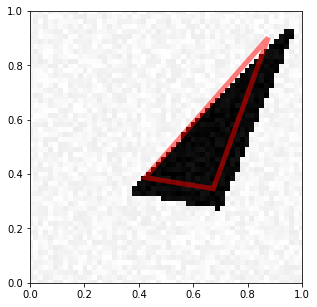

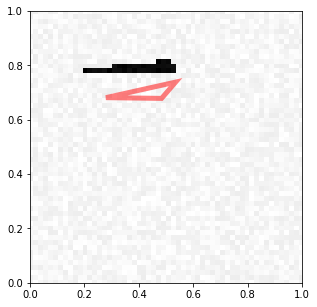

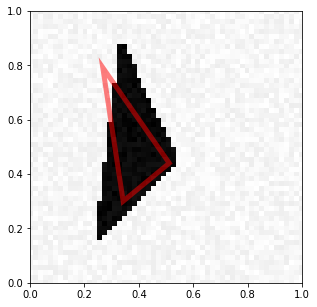

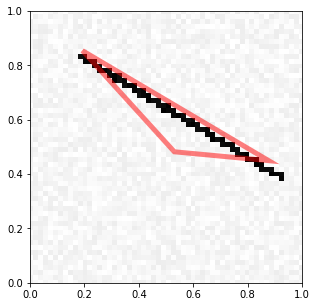

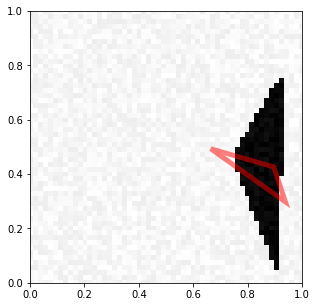

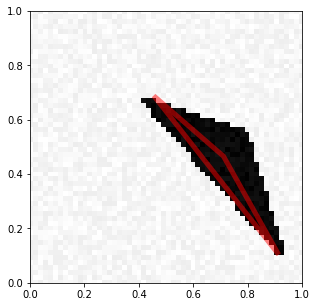

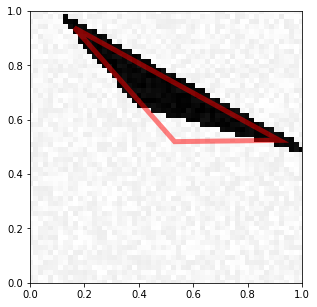

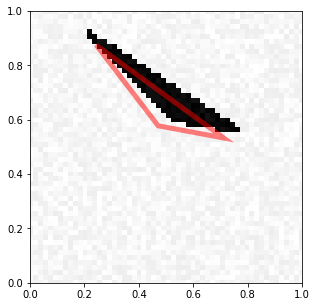

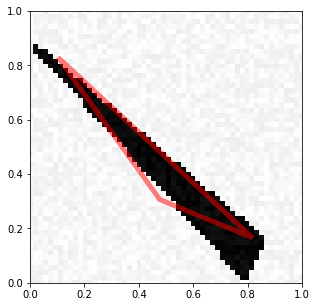

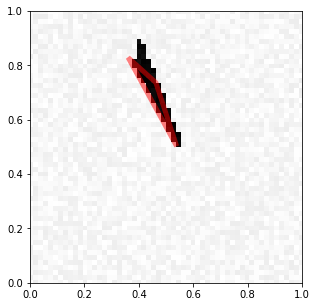

In [252]:
for i in range(10):
    visualize_prediction(X_test[i], Y_pred[i])


Le modèle arrive à détecter où se situe le triangle mais on obtient des résultats surprenants sur certains triangles. On pourrait essayer d'augmenter le nombre de données sur le train set pour un temps d'entrainement plus long.

# Image denoising

In [253]:
#Créee une fonction qui génère une paire d'images (X,Y) avec X image bruitée de Y d'amplitude aléatoire
def generate_dataset_denoising(nb_samples, max_noise=0.0, free_location=True):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, im_size])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 100 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            Y[i] = generate_a_rectangle(0, free_location)
        elif category == 1: 
            Y[i] = generate_a_disk(0, free_location)
        else:
            [Y[i], V] = generate_a_triangle(0, free_location)
            
        temp_noise = np.random.randint(max_noise)
        X[i] = (Y[i] + temp_noise * np.random.random(X.shape[1])) / (255 + 2 * temp_noise)
    Y = Y/255
    return [X, Y]

In [254]:
X_train, Y_train = generate_dataset_denoising(1000, 400)

Creating data:
0
100
200
300
400
500
600
700
800
900


In [255]:
print(X_train.shape)
print(Y_train.shape)

(1000, 5184)
(1000, 5184)


In [256]:
X_train = np.reshape(X_train, (X_train.shape[0], 72 , 72, 1))
Y_train = np.reshape(Y_train, (Y_train.shape[0], 72 , 72, 1))

Ci dessous la visualisation de 9 images bruitées du train set et l'image originale correspondante.

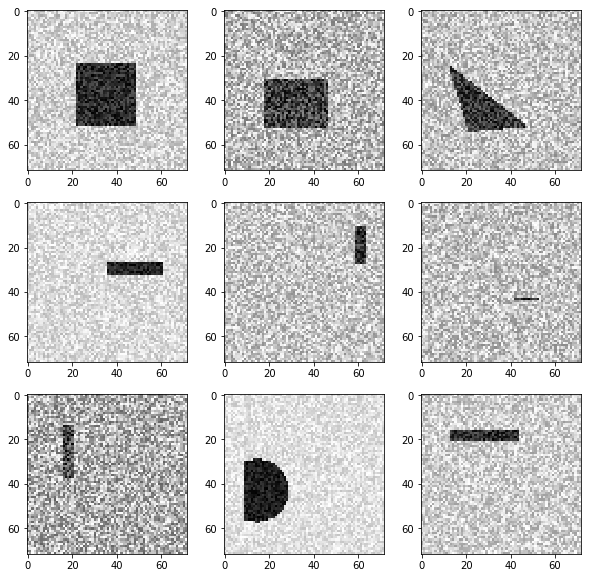

In [258]:
fig = plt.figure(figsize=(10,10))
for i in range(9):
    ax = plt.subplot("33"+str(i))
    ax.imshow(X_train[i].reshape(72,72), cmap='gray')

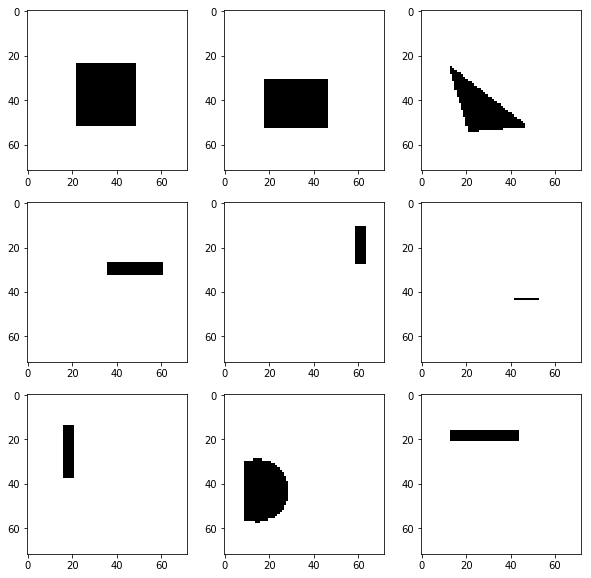

In [257]:
fig = plt.figure(figsize=(10,10))
for i in range(9):
    ax = plt.subplot("33"+str(i))
    ax.imshow(Y_train[i].reshape(72,72), cmap='gray')

In [261]:
model = Sequential()
model.add(Conv2D(16, (3,3) , padding = 'same', activation = 'relu', input_shape=(72, 72, 1)))
print(model.output_shape)
model.add(MaxPooling2D(pool_size=(2, 2)))
print(model.output_shape)

model.add(Conv2D(32,  (3,3) , padding = 'same' , activation = 'relu'))
print(model.output_shape)
model.add(MaxPooling2D(pool_size=(2, 2)))
print(model.output_shape)

model.add(Conv2D(64,  (3,3) , padding = 'same' , activation = 'relu'))
print(model.output_shape)
model.add(MaxPooling2D(pool_size=(2, 2)))
print(model.output_shape)

model.add(Conv2DTranspose(64, (3,3), strides=(2, 2), padding='same', activation = 'relu'))
print(model.output_shape)

model.add(Conv2DTranspose(32, (3,3), strides=(2, 2), padding='same', activation = 'relu'))
print(model.output_shape)

model.add(Conv2DTranspose(32, (3,3), strides=(2, 2), padding='same', activation = 'relu'))
print(model.output_shape)

model.add(Conv2DTranspose(1, (3,3), strides=(1, 1), padding='same', activation = 'sigmoid'))
print(model.output_shape)



(None, 72, 72, 16)
(None, 36, 36, 16)
(None, 36, 36, 32)
(None, 18, 18, 32)
(None, 18, 18, 64)
(None, 9, 9, 64)
(None, 18, 18, 64)
(None, 36, 36, 32)
(None, 72, 72, 32)
(None, 72, 72, 1)


Ci dessus une architecture classique de CNN pour le denosing : dans un premier temps on diminue la taille de l'image avec les max pooling tout en augmentant le nombre de channels, puis on réaugmente la taille avec des Conv2DTranspose jusqu'a obtenir la taille de l'image initiale.

In [262]:
model.compile(loss='binary_crossentropy' , optimizer='adam')
model.fit(X_train, Y_train, epochs=15, batch_size=32)

Epoch 1/15
1000/1000 [==============================] - 22s 22ms/step - loss: 0.4645
Epoch 2/15
1000/1000 [==============================] - 20s 20ms/step - loss: 0.2336
Epoch 3/15
1000/1000 [==============================] - 19s 19ms/step - loss: 0.1100
Epoch 4/15
1000/1000 [==============================] - 18s 18ms/step - loss: 0.0860
Epoch 5/15
1000/1000 [==============================] - 22s 22ms/step - loss: 0.0561
Epoch 6/15
1000/1000 [==============================] - 21s 21ms/step - loss: 0.0291
Epoch 7/15
1000/1000 [==============================] - 20s 20ms/step - loss: 0.0239
Epoch 8/15
1000/1000 [==============================] - 18s 18ms/step - loss: 0.0214
Epoch 9/15
1000/1000 [==============================] - 18s 18ms/step - loss: 0.0192
Epoch 10/15
1000/1000 [==============================] - 21s 21ms/step - loss: 0.0180
Epoch 11/15
1000/1000 [==============================] - 20s 20ms/step - loss: 0.0168
Epoch 12/15
1000/1000 [==============================] - 19s 19

In [263]:
X_test, Y_test = generate_dataset_denoising(200, 400)
X_test = np.reshape(X_test, (X_test.shape[0],72,72,1))
Y_test = np.reshape(Y_test, (Y_test.shape[0],72,72,1))

Creating data:
0
100


In [264]:
model.evaluate(X_test, Y_test)

200/200 [==============================] - 2s 8ms/step


0.014400628209114075

In [265]:
Y = model.predict(X_test)

Ci dessous 9 images du test set bruitées et la prédiction correspondante

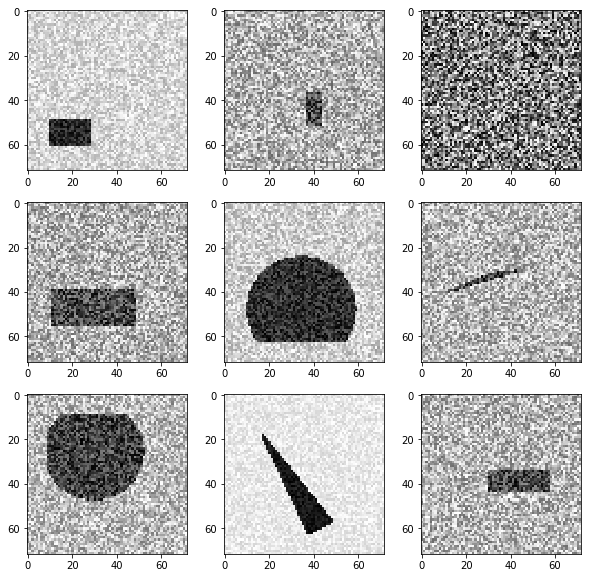

In [266]:
fig = plt.figure(figsize=(10,10))
for i in range(9):
    ax = plt.subplot("33"+str(i))
    ax.imshow(X_test[i].reshape(72,72), cmap='gray')

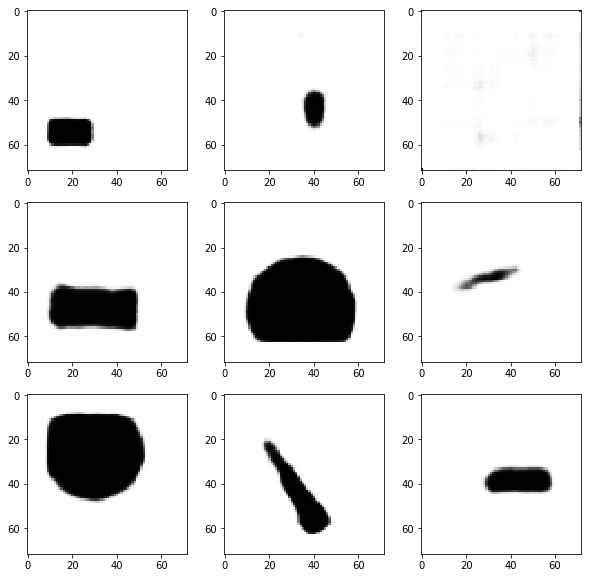

In [267]:
fig = plt.figure(figsize=(10,10))
for i in range(9):
    ax = plt.subplot("33"+str(i))
    ax.imshow(Y[i].reshape(72,72), cmap='gray')

Le modèle arrive à supprimer le bruit de l'arrière plan. Il reste un peu de bruit sur les bords mais les résultats restent satisfaisants pour un modèle relativement simple.